In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/AI Recipe Final Project"

 best_model.h5	    cleaned_dataset.csv			 full_dataset.csv
 best_model.keras   fine_tuned_model.keras		 images.jpg
 class_names.npy   'FOOD-INGREDIENTS dataset.v2i.coco'	 X_train.npy


## **1. Image Dataset Preprocessing**

In [ ]:
!pip install pycocotools opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm

# **Preprocesing function of Image + Annotation**

In [ ]:
def preprocess_image(images_dir, annotation_path, img_size=(224, 224)):
    coco = COCO(annotation_path)
    img_ids = coco.getImgIds()

    X, y = [], []
    for img_id in tqdm(img_ids, desc=f"Processing {os.path.basename(annotation_path)}"):
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        img_path = os.path.join(images_dir, file_name)

        img = cv2.imread(img_path)
        if img is not None:
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

            img = cv2.resize(img, img_size)
            img = img / 255.0
            X.append(img)

            ann_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(ann_ids)
            labels = list(set([ann["category_id"] for ann in anns]))  # ✅ USE category_id
            y.append(labels)

    return np.array(X), y

**Start preprocessing the image dataset (train, valide, and test)**

In [ ]:
base_path = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco"

X_train, y_train = preprocess_image(f"{base_path}/train", f"{base_path}/train/_annotations.coco.json")
X_valid, y_valid = preprocess_image(f"{base_path}/valid", f"{base_path}/valid/_annotations.coco.json")
X_test, y_test = preprocess_image(f"{base_path}/test", f"{base_path}/test/_annotations.coco.json")

loading annotations into memory...
Done (t=10.51s)
creating index...
index created!


Processing _annotations.coco.json: 100%|██████████| 2791/2791 [23:47<00:00,  1.96it/s]


loading annotations into memory...
Done (t=3.25s)
creating index...
index created!


Processing _annotations.coco.json: 100%|██████████| 829/829 [06:12<00:00,  2.23it/s]


loading annotations into memory...
Done (t=2.66s)
creating index...
index created!


Processing _annotations.coco.json: 100%|██████████| 575/575 [04:44<00:00,  2.02it/s]


Encode Multi-Label Outputs

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_valid = mlb.transform(y_valid)
y_test = mlb.transform(y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [115, 2, 47, 82, 83] will be ignored
  warnings.warn(


In [ ]:
np.save("/content/drive/MyDrive/AI Recipe Final Project/class_names.npy", mlb.classes_)

Train CNN model (ResNet50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,695,795 (94.21 MB)

 Trainable params: 1,108,083 (4.23 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train the model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          epochs=30,
          batch_size=32,
          callbacks=[early_stop])

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - binary_accuracy: 0.7419 - loss: 0.5024 - val_binary_accuracy: 0.9907 - val_loss: 0.0590
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - binary_accuracy: 0.9898 - loss: 0.0640 - val_binary_accuracy: 0.9907 - val_loss: 0.0519
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - binary_accuracy: 0.9897 - loss: 0.0589 - val_binary_accuracy: 0.9907 - val_loss: 0.0516
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - binary_accuracy: 0.9898 - loss: 0.0575 - val_binary_accuracy: 0.9907 - val_loss: 0.0515
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - binary_accuracy: 0.9898 - loss: 0.0570 - val_binary_accuracy: 0.9907 - val_loss: 0.0515
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - binary_accuracy: 0.9897 - loss: 0.0564 - val_binary_accuracy: 0.9907 - val_loss: 0.0514
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - binary_accuracy: 0.9899 - loss: 0.0554 - val_binary_accuracy: 0.9907 - val_loss: 0.0511
Epoch 8/30
88

Save the model

In [ ]:
# Save in modern Keras format
model.save('best_model.keras')

# Also save in legacy HDF5 format (optional)
model.save('best_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/AI Recipe Final Project/best_model.h5", compile=False)

In [ ]:
# Unfreeze some or all layers of the base model
for layer in model.layers:
    layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          epochs=10,  # fewer epochs is often enough
          batch_size=32,
          callbacks=[early_stop])

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - binary_accuracy: 0.9893 - loss: 0.0707 - val_binary_accuracy: 0.9907 - val_loss: 0.0548
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 543s 6s/step - binary_accuracy: 0.9895 - loss: 0.0554 - val_binary_accuracy: 0.9907 - val_loss: 0.0541
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - binary_accuracy: 0.9901 - loss: 0.0455 - val_binary_accuracy: 0.9907 - val_loss: 0.0535
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - binary_accuracy: 0.9905 - loss: 0.0404 - val_binary_accuracy: 0.9907 - val_loss: 0.0531
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - binary_accuracy: 0.9908 - loss: 0.0365 - val_binary_accuracy: 0.9907 - val_loss: 0.0539
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - binary_accuracy: 0.9914 - loss: 0.0320 - val_binary_accuracy: 0.9907 - val_loss: 0.0537
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - binary_accuracy: 0.9920 - loss: 0.0286 - val_binary_accuracy: 0.9907 - val_loss: 0.0507
Epoch 8/10
88

**Evaluate**

In [ ]:
ា

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - binary_accuracy: 0.9920 - loss: 0.0333
Test Loss: 0.0332
Test Accuracy: 99.21%


**Save the fine-tuned model**

In [ ]:
model.save("/content/drive/MyDrive/AI Recipe Final Project/fine_tuned_model.keras")

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

target_names = [str(label) for label in mlb.classes_]

print(classification_report(y_test, y_pred_bin, target_names=target_names, zero_division=0))

18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.43      0.60         7
           4       0.00      0.00      0.00        10
           5       1.00      0.12      0.22         8
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         4
          10       1.00      0.23      0.37        22
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         4
          14       0.00      0.00      0.00         2
          15       1.00      0.25      0.40        12
          16       1.00      0.67      0.80         3
          17       0.00      0.00      0.00         1
          18       1.00      0.13      0.2

In [ ]:
from sklearn.metrics import classification_report

nonzero_label_indices = np.where(np.sum(y_test, axis=0) > 0)[0]
filtered_y_test = y_test[:, nonzero_label_indices]
filtered_y_pred = y_pred_bin[:, nonzero_label_indices]
filtered_target_names = [str(mlb.classes_[i]) for i in nonzero_label_indices]

print(classification_report(filtered_y_test, filtered_y_pred, target_names=filtered_target_names, zero_division=0))

              precision    recall  f1-score   support

           3       1.00      0.43      0.60         7
           4       0.00      0.00      0.00        10
           5       1.00      0.12      0.22         8
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         4
          10       1.00      0.23      0.37        22
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         4
          14       0.00      0.00      0.00         2
          15       1.00      0.25      0.40        12
          16       1.00      0.67      0.80         3
          17       0.00      0.00      0.00         1
          18       1.00      0.13      0.24        15
          19       0.00      0.00      0.00         2
          20       1.00    

# **TESTING**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving images.jpg to images.jpg


In [ ]:
import cv2
import numpy as np

# Get the uploaded filename
filename = list(uploaded.keys())[0]

# Load and preprocess
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)  # shape: (1, 224, 224, 3)

In [ ]:
from tensorflow.keras.models import load_model

# Load model
model_path = "/content/drive/MyDrive/AI Recipe Final Project/fine_tuned_model.keras"
model = load_model(model_path)

# Load class labels
class_names = np.load("/content/drive/MyDrive/AI Recipe Final Project/class_names.npy", allow_pickle=True)

In [ ]:
# Predict
prediction = model.predict(img)[0]

# Convert to label names using threshold
threshold = 0.5  # you can lower it to 0.4 or 0.3 if predictions are too strict
predicted_ingredients = [class_names[i] for i, prob in enumerate(prediction) if prob > threshold]

# Show result
if predicted_ingredients:
    print("🍽️ Predicted Ingredients:", predicted_ingredients)
else:
    print("❌ No ingredients detected confidently.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
❌ No ingredients detected confidently.


**Checking the ingredients in the trained dataset**

In [ ]:
import json

# Load the COCO annotation file (you can use train/valid/test — they should all have the same categories)
annotation_path = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco/train/_annotations.coco.json"

with open(annotation_path, 'r') as f:
    coco_data = json.load(f)

# Build mapping from category ID to name
id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}


In [ ]:
# Now convert the class names using this mapping
readable_class_names = [id_to_name[int(c)] for c in class_names]

# Show final result
print(f"✅ Total ingredient classes: {len(readable_class_names)}\n")
print("🧾 Ingredients your model was trained to detect:\n")
for i, name in enumerate(readable_class_names):
    print(f"{i+1}. {name}")


✅ Total ingredient classes: 115

🧾 Ingredients your model was trained to detect:

1. Akabare Khursani
2. Artichoke
3. Ash Gourd -Kubhindo-
4. Asparagus -Kurilo-
5. Avocado
6. Bacon
7. Bamboo Shoots -Tama-
8. Banana
9. Beans
10. Beaten Rice -Chiura-
11. Beef
12. Beetroot
13. Bethu ko Saag
14. Bitter Gourd
15. Black Lentils
16. Black beans
17. Bottle Gourd -Lauka-
18. Bread
19. Brinjal
20. Broad Beans -Bakullo-
21. Broccoli
22. Buff Meat
23. Butter
24. Cabbage
25. Capsicum
26. Carrot
27. Cassava -Ghar Tarul-
28. Cauliflower
29. Chayote-iskus-
30. Cheese
31. Chicken
32. Chicken Gizzards
33. Chickpeas
34. Chili Pepper -Khursani-
35. Chili Powder
36. Chowmein Noodles
37. Cinnamon
38. Coriander -Dhaniya-
39. Corn
40. Cornflakec
41. Crab Meat
42. Cucumber
43. Egg
44. Farsi ko Munta
45. Fiddlehead Ferns -Niguro-
46. Garden Peas
47. Garden cress-Chamsur ko saag-
48. Garlic
49. Ginger
50. Green Brinjal
51. Green Lentils
52. Green Mint -Pudina-
53. Green Peas
54. Green Soyabean -Hariyo Bhatmas-
5

**Convert the image that has multi-labels to binary format**

# **Text Dataset Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, TFAutoModel
import matplotlib.pyplot as plt

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
text_dataset = "/content/drive/MyDrive/AI Recipe Final Project/full_dataset.csv"
chunk_size = 10000

In [ ]:
def map_to_category(name):
    name = str(name).lower()
    if "chicken" in name: return "chicken"
    if "beef" in name: return "beef"
    if "soup" in name: return "soup"
    if "salad" in name: return "salad"
    if "noodle" in name or "pasta" in name: return "noodles"
    if any(x in name for x in ["cake", "cookie", "chocolate", "dessert"]): return "dessert"
    if "tofu" in name or "vegan" in name or "vegetarian" in name: return "vegetarian"
    return "other"

In [ ]:
X_all = []
y_all = []

for chunk in pd.read_csv(text_dataset, chunksize=chunk_size):
    chunk = chunk.iloc[:, :4]
    chunk.columns = ["No", "Recipe", "Ingredients", "Instructions"]
    chunk.dropna(inplace=True)
    chunk["Category"] = chunk["Recipe"].apply(map_to_category)

    combined = (chunk["Ingredients"].astype(str) + " " + chunk["Instructions"].astype(str)).tolist()
    labels = chunk["Category"].tolist()

    tokens = tokenizer(
        combined,

        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="np")

    X_all.extend(tokens["input_ids"])
    y_all.extend(labels)

X_all = np.vstack(X_all)
y_all = np.array(y_all)

Encode label

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)

In [ ]:
joblib.dump(label_encoder, "/content/drive/MyDrive/AI Recipe Final Project/label_encoder.pkl")

['/content/drive/MyDrive/AI Recipe Final Project/label_encoder.pkl']

Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Dataset ready — Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Dataset ready — Train shape: (1784912, 256), Test shape: (446229, 256)


Training BERT Model

In [ ]:
bert_model = TFAutoModel.from_pretrained("bert-base-uncased")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda
import tensorflow as tf


input_ids = Input(shape=(256,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(256,), dtype=tf.int32, name='attention_mask')

def extract_bert_cls(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]  # Take [CLS] token
    return cls_token

In [ ]:
bert_cls = Lambda(extract_bert_cls, output_shape=(768,))([input_ids, attention_mask])

In [ ]:
output = Dense(len(label_encoder.classes_), activation='softmax')(bert_cls)

In [ ]:
final_model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [ ]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      6,152 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,152 (24.03 KB)

 Trainable params: 6,152 (24.03 KB)

 Non-trainable params: 0 (0.00 B)

Train

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = final_model.fit(
    {"input_ids": X_train, "attention_mask": np.ones_like(X_train)},
    y_train,
    validation_data=(
        {"input_ids": X_test, "attention_mask": np.ones_like(X_test)},
        y_test
    ),
    epochs=5,
    batch_size=256,
    callbacks=[early_stop]
)

Epoch 1/5
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 1743s 247ms/step - accuracy: 0.6014 - loss: 1.2521 - val_accuracy: 0.6642 - val_loss: 1.0304
Epoch 2/5
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 1711s 245ms/step - accuracy: 0.6673 - loss: 1.0087 - val_accuracy: 0.6768 - val_loss: 0.9604
Epoch 3/5
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 1711s 245ms/step - accuracy: 0.6782 - loss: 0.9495 - val_accuracy: 0.6875 - val_loss: 0.9195
Epoch 4/5
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 1711s 245ms/step - accuracy: 0.6886 - loss: 0.9116 - val_accuracy: 0.6940 - val_loss: 0.8917
Epoch 5/5
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 1711s 245ms/step - accuracy: 0.6951 - loss: 0.8876 - val_accuracy: 0.7005 - val_loss: 0.8712


**Unfreeze all layer to get more accuracy**

In [ ]:
for layer in bert_model.layers:
    layer.trainable = True

In [ ]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Recompile the model**

In [ ]:
history_fine = final_model.fit(
    {"input_ids": X_train, "attention_mask": np.ones_like(X_train)},
    y_train,
    validation_data=(
        {"input_ids": X_test, "attention_mask": np.ones_like(X_test)},
        y_test
    ),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2248s 20ms/step - accuracy: 0.7042 - loss: 0.8562 - val_accuracy: 0.7139 - val_loss: 0.8228
Epoch 2/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2219s 20ms/step - accuracy: 0.7159 - loss: 0.8159 - val_accuracy: 0.7210 - val_loss: 0.7973
Epoch 3/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2220s 20ms/step - accuracy: 0.7219 - loss: 0.7940 - val_accuracy: 0.7250 - val_loss: 0.7810
Epoch 4/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2220s 20ms/step - accuracy: 0.7270 - loss: 0.7769 - val_accuracy: 0.7294 - val_loss: 0.7691
Epoch 5/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2221s 20ms/step - accuracy: 0.7292 - loss: 0.7673 - val_accuracy: 0.7318 - val_loss: 0.7599
Epoch 6/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2222s 20ms/step - accuracy: 0.7326 - loss: 0.7572 - val_accuracy: 0.7336 - val_loss: 0.7528
Epoch 7/10
111557/111557 ━━━━━━━━━━━━━━━━━━━━ 2221s 20ms/step - accuracy: 0.7344 - loss: 0.7500 - val_accuracy: 0.7349 - val_loss: 0.7467
Epoch 8/10
111557/111557 ━━━━━━━━━

In [ ]:
y_pred_probs = final_model.predict(
    {"input_ids": X_test, "attention_mask": np.ones_like(X_test)},
    batch_size=256
)

y_pred_classes = np.argmax(y_pred_probs, axis=1)

1744/1744 ━━━━━━━━━━━━━━━━━━━━ 347s 197ms/step


**Get classification report**

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        beef       0.53      0.09      0.15      8608
     chicken       0.85      0.50      0.63     35198
     dessert       0.72      0.45      0.55     62521
     noodles       0.36      0.10      0.16      5399
       other       0.74      0.94      0.83    292038
       salad       0.67      0.22      0.34     27884
        soup       0.64      0.13      0.22     12217
  vegetarian       0.39      0.01      0.01      2364

    accuracy                           0.74    446229
   macro avg       0.61      0.31      0.36    446229
weighted avg       0.73      0.74      0.70    446229



Plot Accuracy and Loss

In [ ]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Accuracy

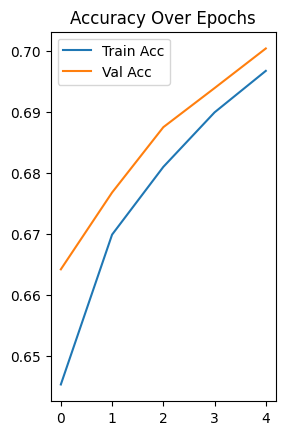

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.legend()

Loss

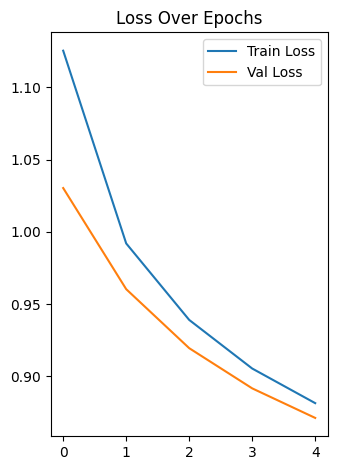

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_model.save("/content/drive/MyDrive/AI Recipe Final Project/text_bert_model.h5")